# Graph state compiler overview

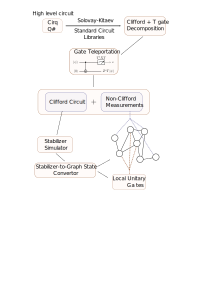

In [1]:
open("compiler.svg") do f
   display("image/svg+xml", read(f, String))
end

The compiler can be broken into the following stages

### Circuit Initialisation

1. Receives input of a Cirq Circuit instance. 
2. Generates a Clifford + T decomposition - At the moment we use Cirq's native decomposition methods. This does not support arbitarty rotations yet (Solovay-Kitaev in the workflow diagram). This feature can be added by integrating packages from Peter Selinger's group https://hackage.haskell.org/package/newsynth


### ICM decomposition

3. The package icm converts implements all T gates in the Clifford + T circuit using a CNOT and a measurement in a non-stabilizer basis. This is basically gate teleportation. This allows any circuit to be broken up into a stabilizer state initialisation followed by a round of non-stabilizer measurements. The technical challange being solved is that the compiler needs to keep track of where each qubit is being teleported during the decomposition process. This is done by adding flags to the circuit operations and qubits. 

### Stabalizer Simulator ( Julia - this is the guts of Jabalizer)

4. The stabilizer simulator is basically a wrapper around stim and it's Tableau simulator. The compiler will now simulate the pre-measurement Clifford part of the circuit by maping the circuit gates to stabilizer operations. 

### Graph conversion
5. The final stabilizer state is converted into a graph state using Jabalizer's inbuilt graph conversion algorithm. This is the algorithm specific graph state which will be used for benchmarking. 


### Import Jabalizer and PyCall which is a library to use python packages in Julia

In [2]:
using Jabalizer
using JSON

┌ Info: Precompiling Jabalizer [5ba14d91-d028-496b-b148-c0fbc366f709]
└ @ Base loading.jl:1423
┌ Warning: Package Jabalizer does not have JSON in its dependencies:
│ - If you have Jabalizer checked out for development and have
│   added JSON as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Jabalizer
└ Loading JSON into Jabalizer from project dependency, future warnings for Jabalizer are suppressed.


### Import cirq

In [3]:
using PythonCall
cirq = pyimport("cirq");

## Example circuit decomposition

## Controlled-$V^{\dagger}$ with input $| 00 \rangle$

### import a circuit from file

In [4]:
circuit_file_name = "circuits/control_v.json"
circuit_string = cirq.read_json(circuit_file_name)
cirq_circuit = cirq.read_json(json_text=circuit_string)

Python Circuit:
cirq.Circuit([
    cirq.Moment(
        (cirq.T**-1).on(cirq.LineQubit(0)),
        cirq.H(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.T(cirq.LineQubit(0)),
        (cirq.T**-1).on(cirq.LineQubit(1)),
    ),
    cirq.Moment(
        cirq.CNOT(cirq.LineQubit(1), cirq.LineQubit(0)),
    ),
    cirq.Moment(
        cirq.H(cirq.LineQubit(1)),
    ),
])

### ICM decomposition

The T gates in the above circuit are replaced by CNOTs to an ancilla and a measurement.

In [ ]:
gates_to_decomp = ["T", "T^-1"];
icm_input = Jabalizer.load_circuit_from_cirq_json("circuits/control_v.json")
icm_circuit = Jabalizer.compile(icm_input, gates_to_decomp)

### Load circuit back to CirQ

Currently the option to go back and forth between CirQ and Jabalizer is a little bit clunky, as you need to save the ICM output to json and later read it from cirq. This is definitely one of the quality of life improvements that we will work on in future!

In [ ]:
Jabalizer.save_circuit_to_cirq_json(icm_circuit, "icm_output.json");
cirq_circuit = cirq.read_json("icm_output.json")
rm("icm_output.json")

### Stabilizer simulation.
The circuit gates excluding the final measurements are simulated using the stabilizer simulator (Jabalizer)

In [ ]:
n_qubits = Jabalizer.count_qubits(icm_circuit)
state = Jabalizer.zero_state(n_qubits);

print(state)

In [ ]:
Jabalizer.execute_circuit(state, icm_circuit)
print(state)

### Graph state conversion
The final stabilizer state is now converted into a an algorithm specific graph state. All stabilizer states can be converted to an equivalent graph state and the funtion `ToGraph` is used for this conversion. 

In [ ]:
(g,A,seq) = Jabalizer.to_graph(state)
Jabalizer.gplot(g)

ToGraph returns the graph state `g`

In [ ]:
print(g)

The adjecency matrix defining the graph `A`. This is what will be used to benchmark the circuit,

In [ ]:
display(A)

And a the sequence of local unitary operations required to convert the graph state back to the pre-measurement stabilizer output of the initial circuit `seq`

In [ ]:
seq

## Control - $V^{\dagger}$ with input |+0>

In [ ]:
circuit_file_name = "circuits/control_v.json"
circuit_string = cirq.read_json(circuit_file_name)
cirq_circuit = cirq.read_json(json_text=circuit_string)

In [ ]:
qubits = sort([q for q in  cirq_circuit.all_qubits()])

In [ ]:
cirq_circuit.insert(0, cirq.H(qubits[1]));

In [ ]:
cirq_circuit

In [ ]:
json_string = pyconvert(String, cirq.to_json(cirq_circuit))
open("temp_circuit.json", "w") do f
    write(f, json_string);
end

input_circuit = Jabalizer.load_circuit_from_cirq_json("temp_circuit.json")
rm("temp_circuit.json")

In [ ]:
gates_to_decomp = ["T", "T^-1"];
icm_circuit = Jabalizer.compile(input_circuit, gates_to_decomp)

In [ ]:
n_qubits = Jabalizer.count_qubits(icm_circuit)
state = Jabalizer.zero_state(n_qubits);
print(state)

In [ ]:
Jabalizer.execute_circuit(state, icm_circuit)
print(state)

In [ ]:
(g,A,seq) = Jabalizer.to_graph(state)
Jabalizer.gplot(g)

In [ ]:
seq

## Toffolli gate with input |000>

In [ ]:
qubits = [cirq.LineQubit(i) for i in 0:2]

In [ ]:
cirq_circuit = cirq.Circuit();

In [ ]:
cirq_circuit.append(cirq.CCNOT(qubits...))

In [ ]:
cirq_circuit

### Clifford + T decomposition using native cirq methods

Using the following method in cirq, one can decompose a Toffolli gate to a circuit of Clifford + T gates. <br>
It's easy to do in Python, however not straightforward to do inside a Julia notebook, hence we're loading a circuit from a json. <br>
In order to do it yourself in Python, you need to define the following function:
```python
def keep_clifford_plus_T(op):
    if isinstance(op.gate, (cirq.XPowGate,
                            cirq.YPowGate,
                            cirq.ZPowGate,
                            cirq.HPowGate,
                            cirq.CNotPowGate,
                            cirq.SwapPowGate
                            )):
        return True
```

and then run it like this:

```python
qubits = [cirq.LineQubit(i) for i in range(3)]
cirq_circuit = cirq.Circuit()
cirq_circuit.append(cirq.CCNOT(*qubits))
ct_circuit = cirq.Circuit(cirq.decompose(cirq_circuit, keep=keep_clifford_plus_T))
```

Original circuit:
```
0: ───@───
      │
1: ───@───
      │
2: ───X───
```

Decomposed circuit:
```

0: ───T───@──────────────@───────@──────────@──────────────
          │              │       │          │
1: ───T───X───@───T^-1───X───@───X──────@───X──────@───────
              │              │          │          │
2: ───H───T───X───T──────────X───T^-1───X───T^-1───X───H───
```

(If you know how to embed this in the Julia notebook for a better experience, feel free to make a PR!)

In [ ]:
input_circuit = Jabalizer.load_circuit_from_cirq_json("circuits/toffoli_circuit_1.json")
gates_to_decomp = ["T", "T^-1"];
icm_circuit = Jabalizer.compile(input_circuit, gates_to_decomp);

In [ ]:
n_qubits = Jabalizer.count_qubits(icm_circuit)
state = Jabalizer.zero_state(n_qubits);
Jabalizer.execute_circuit(state, icm_circuit)
print(state)

In [ ]:
(g,A,seq) = Jabalizer.to_graph(state)
Jabalizer.gplot(g)

### Toffoli with input |+00>

Original circuit:

```
0: ───H───@───
          │
1: ───────@───
          │
2: ───────X───
```

Decomposed circuit:

```
0: ───H───T───@──────────────@───────@──────────@──────────────
              │              │       │          │
1: ───H───T───X───@───T^-1───X───@───X──────@───X──────@───────
                  │              │          │          │
2: ───H───T───────X───T──────────X───T^-1───X───T^-1───X───H───
```

In [ ]:
input_circuit = Jabalizer.load_circuit_from_cirq_json("circuits/toffoli_circuit_2.json")
gates_to_decomp = ["T", "T^-1"];
icm_circuit = Jabalizer.compile(input_circuit, gates_to_decomp);

In [ ]:
n_qubits = Jabalizer.count_qubits(icm_circuit)
state = Jabalizer.zero_state(n_qubits);
Jabalizer.execute_circuit(state, icm_circuit)
print(state)

In [ ]:
(g,A,seq) = Jabalizer.to_graph(state)
Jabalizer.gplot(g)

### Toffoli with input |++0>

Original circuit:

```
0: ───H───@───
          │
1: ───H───@───
          │
2: ───────X───
```

Decomposed circuit:

```
0: ───H───T───@──────────────@───────@──────────@──────────────
              │              │       │          │
1: ───H───T───X───@───T^-1───X───@───X──────@───X──────@───────
                  │              │          │          │
2: ───H───T───────X───T──────────X───T^-1───X───T^-1───X───H───
```

In [ ]:
input_circuit = Jabalizer.load_circuit_from_cirq_json("circuits/toffoli_circuit_3.json")
gates_to_decomp = ["T", "T^-1"];
icm_circuit = Jabalizer.compile(input_circuit, gates_to_decomp);

In [ ]:
n_qubits = Jabalizer.count_qubits(icm_circuit)
state = Jabalizer.zero_state(n_qubits);
Jabalizer.execute_circuit(state, icm_circuit)
print(state)

In [ ]:
(g,A,seq) = Jabalizer.to_graph(state)
Jabalizer.gplot(g)